#### Лаба 2
#### Алгоритмы слежения за траекторией

Дано:
| Variant | Robot type | $\xi_0^T=[x_0\,\,\, y_0\,\,\, \vartheta_0]^T$ | $R_1$ | $\delta$ | Direction 1 | $\alpha$ | $t$ | $R_2$ | Direction 3 |
| :--------: | :-------: | :-------: | :-------: | :-------: | :-------: | :-------: | :-------: | :-------: | :-------: |
| 5 | (1,2) | $[0\,\,\, 3\,\,\,\frac{2\pi}{3}]^T$ | 7 | $2\pi$ | positive | $\frac{\pi}{3}$ | 6 |12 |clockwise |

положение робота: $\xi_b=\begin{bmatrix} x \\ y\\ \vartheta \end{bmatrix}$

поворотная матрица: $R_b^m(\vartheta)=\begin{bmatrix} cos\vartheta & sin\vartheta & 0\\ -sin\vartheta & cos\vartheta & 0 \\ 0 & 0 & 1 \end{bmatrix}$,  $\xi_b \xmapsto{R_b^m} \xi_m$

Позиционная динамическая модель c моментным управлением:
$$\dot z = B(z) u $$
$$\dot u = v$$
где $z = \begin{bmatrix} \xi \\ \beta_s \end{bmatrix}$, и $u=\begin{bmatrix} \eta \\ \zeta \end{bmatrix}$, и $v=\begin{bmatrix} v_1 \\ v_2 \end{bmatrix}$,  $B(z)=\begin{bmatrix} R^T(\vartheta)\Sigma(\beta_s) & 0 \\ 0 & I \end{bmatrix}$

Подробное описание вывода формул в [model and control LAB2.md](./specifications/model_and_control_LAB2.md)

In [717]:
import sympy as sm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from IPython.display import display, Math
import inspect

### Robot raw model with simulation

In [718]:
# robot model parameters
L = 0.2 # in m
e = 0.2 # in m

In [719]:
beta_s1, beta_s2, theta, x, y, eta, zeta_1, zeta_2  = sm.symbols("beta_s1 beta_s2 theta x y eta zeta_1 zeta_2")
Sigma = sm.Matrix( [[-2*L*sm.sin(beta_s1)*sm.sin(beta_s2)],[L*sm.sin(beta_s1+beta_s2)],[sm.sin(beta_s2-beta_s1)]] )
R = sm.Matrix( [[sm.cos(theta),sm.sin(theta),0],[-sm.sin(theta),sm.cos(theta),0],[0,0,1]] )
xi = sm.Matrix([[x],[y],[theta]])
u = sm.Matrix([[eta],[zeta_1],[zeta_2]])
z = sm.Matrix([[xi],[beta_s1],[beta_s2]])
z3 = sm.Matrix([[theta],[beta_s1]])
B = sm.Matrix( [[R.T*Sigma, sm.zeros(3,2)],[sm.zeros(2,1), sm.eye(2)]] )
z1 = sm.Matrix([[x+L*sm.cos(theta)+e*sm.cos(theta+beta_s1+np.pi/2)],[y+L*sm.sin(theta)+e*sm.sin(theta+beta_s1+np.pi/2)],[beta_s2]])  

In [720]:
def display_expr(expr):
    frame = inspect.currentframe()
    frame = inspect.getouterframes(frame)[1]
    string = inspect.getframeinfo(frame[0]).code_context[0].strip()
    args = string[string.find('(') + 1:-1].split(',')
    
    names = []
    for i in args:
        if i.find('=') != -1:
            names.append(i.split('=')[1].strip())
        
        else:
            names.append(i)
    if names[0]=='Sigma':
        names[0] = '\\Sigma'
    if names[0]=='xi':
        names[0]='\\xi'
    if names[0]=='z1':
        names[0]='z_1'
    if names[0]=='z2':
        names[0]='z_2'
    if names[0]=='z3':
        names[0]='z_3'
    if names[0]=='Kinv':
        names[0]='K^{-1}'
    if names[0]=='Kinv_map':
        names[0]='\\overline{K^{-1}}'
    if names[0]=='z1d':
        names[0]='z_{1d}'
    if names[0]=='dot_z1d':
        names[0]='\\dot z_{1d}'
    if names[0]=='ddot_z1d':
        names[0]='\\ddot z_{1d}'
    if names[0]=='dhdz':
        names[0]='\\cfrac{\partial h(z)}{\partial z}'
    if names[0]=='lambda_1':
        names[0]='\\Lambda_1'
    if names[0]=='lambda_2':
        names[0]='\\Lambda_2'
    if names[0]=='dotz1':
        names[0]='\\dot z_1'
    if names[0]=='K_map':
        names[0]='\\overline{K}'
    if names[0]=='g_map':
        names[0]='\\overline{g}'
    if names[0]=='Bu_map':
        names[0]='\\overline{Bu}'
    expr = expr.xreplace({n : round(n, 3) for n in expr.atoms(sm.Number)})
    str = sm.latex(expr)
    str = str.replace('\\theta','\\vartheta')

    display(Math(names[0] + '=' + str))    

In [721]:
display_expr(Sigma)
display_expr(R)
display_expr(B)
display_expr(xi)
display_expr(z)
display_expr(u)
display_expr(z1)
display_expr(z3)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [722]:
Bu = B*u
display_expr(Bu)

<IPython.core.display.Math object>

In [723]:
# function prepearing and checking
params = (eta,zeta_1,zeta_2,theta,beta_s1,beta_s2)
fun_Bu = sm.lambdify(params, Bu, modules='numpy')
# fun_B(3,8,0.5,0.1,0.2,1)

params = (x,y,theta,beta_s1,beta_s2)
fun_z1 = sm.lambdify(params, z1, modules='numpy')
# fun_z(3,8,0.5,0.1,0.2)

In [724]:
def rhs_Bu(t, z, eta, zeta_1, zeta_2):
    x,y,theta,beta_s1,beta_s2 = z
    if beta_s1 < 1e-1:
        beta_s1 = 1e-1
    elif beta_s1 > np.pi - 1e-1:
        beta_s1 = np.pi - 1e-1
    return fun_Bu(eta,zeta_1,zeta_2,theta,beta_s1,beta_s2).reshape(1,5)[0]

In [725]:
T = 70 # simulation time
z0 = [0,0,-np.pi/2,0.1,0]
sol = sp.integrate.solve_ivp(rhs_Bu, [0, T], z0, args=(1, np.pi/120, np.pi/100),
                dense_output=True)

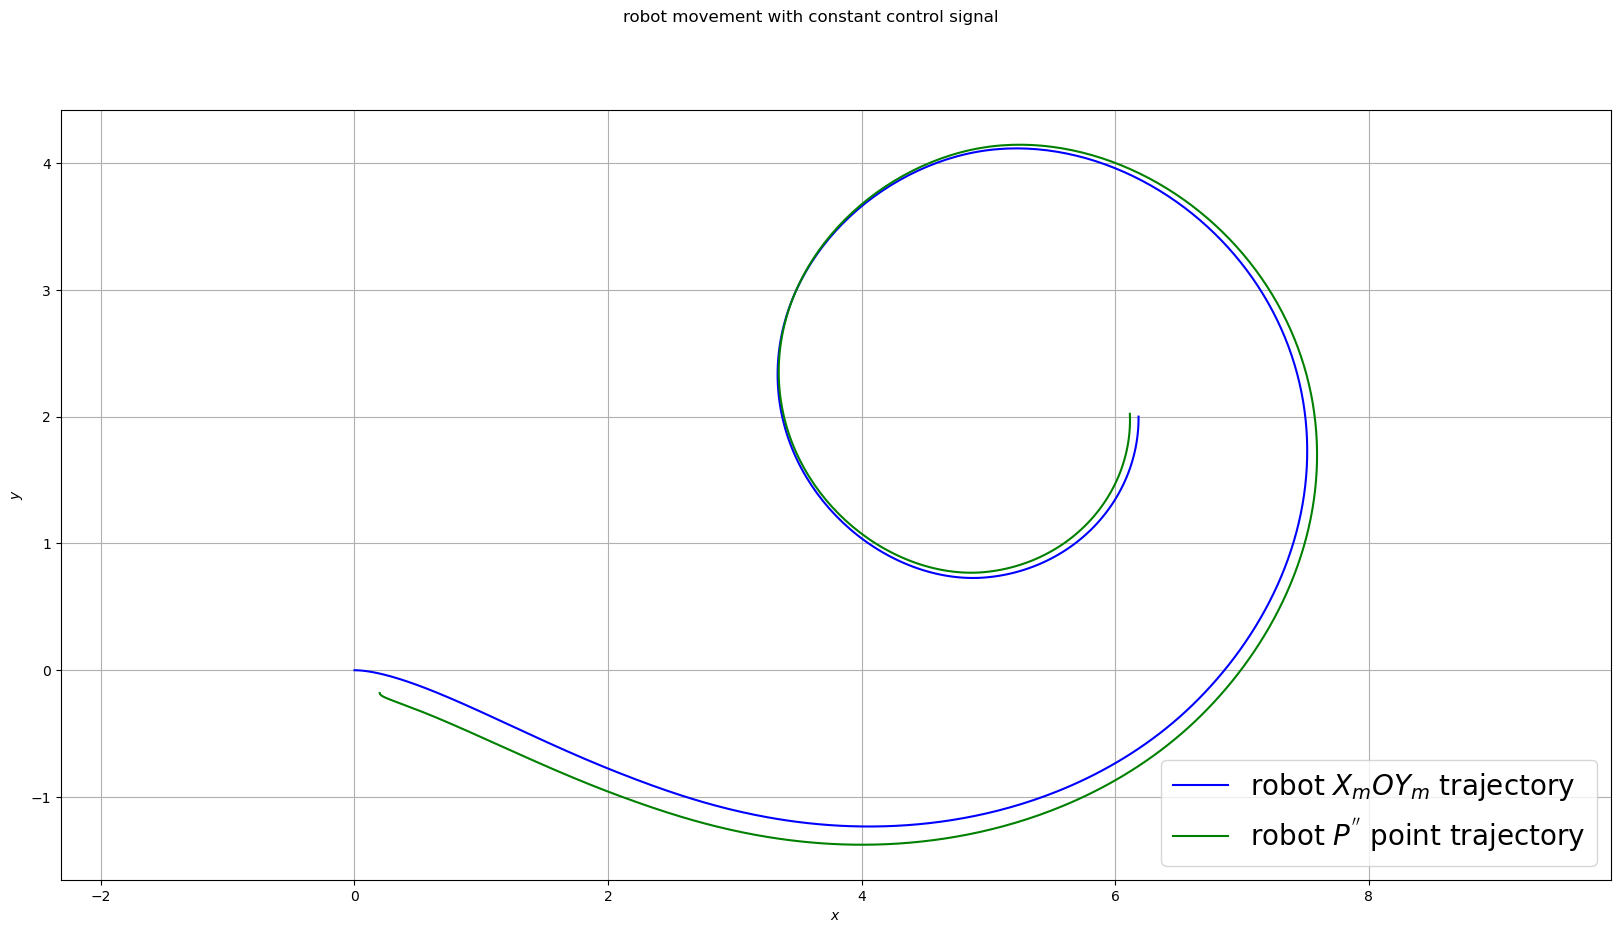

In [726]:
dt = 0.1
t = np.linspace(0, T, round(T/dt))
z_traj = sol.sol(t)
# computing z1
z1_traj = np.array([]).reshape(3,0)
for i in range(len(t)):
    z1_traj = np.hstack((z1_traj,fun_z1(z_traj[0][i],z_traj[1][i],z_traj[2][i],z_traj[3][i],z_traj[4][i])))
fig, ax = plt.subplots(1,1,figsize = (20,10))
labels = ['robot $X_mOY_m$ trajectory','robot $P^{\'\'}$ point trajectory','$\mathcal{C}^2$']
colours = ['b','g','orange']
ax.plot(z_traj[0],z_traj[1],label=labels[0],color=colours[0])
ax.plot(z1_traj[0],z1_traj[1],label=labels[1],color=colours[1])

fig.suptitle("robot movement with constant control signal")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.grid(True)
ax.legend(fontsize="20",loc='lower right')
ax.axis('equal')
plt.show()

### Static state feedback

In [727]:
dhdz1 = sm.diff(z1,z.T)
dhdz1 = dhdz1[0]
dhdz = sm.Matrix([])
for i in range(sm.shape(dhdz1)[0]):
    dhdz = sm.Matrix.hstack(dhdz,sm.Matrix(dhdz1[i]))
del dhdz1
display_expr(dhdz)

<IPython.core.display.Math object>

In [728]:
K = dhdz*B
display_expr(K)

<IPython.core.display.Math object>

In [729]:
dKdz1 = sm.diff(K*u,z.T)
dKdz1 = dKdz1[0]
dKudz = sm.Matrix([])
for i in range(sm.shape(dKdz1)[0]):
    dKudz = sm.Matrix.hstack(dKudz,sm.Matrix(dKdz1[i]))
del dKdz1
g = dKudz*B*u
display_expr(g)

<IPython.core.display.Math object>

mapping
$$\begin{bmatrix} \xi \\ \beta_s \end{bmatrix} \xmapsto{} \begin{bmatrix} h(z) \\ k(z) \end{bmatrix} $$

In [730]:
z_map = sm.Matrix([[z1],[z3]])
replacements = [(z[i], z_map[i]) for i in range(sm.shape(z)[0])]
K_map = K.subs(replacements,simultaneous=True)
display_expr(K_map)
g_map = g.subs(replacements,simultaneous=True)
display_expr(g_map)
# Bu_map = Bu.subs(replacements,simultaneous=True)
# display_expr(Bu_map)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [731]:
# Kinv_map = K_map.inv()
# display_expr(Kinv_map)

In [732]:
# reference smooth trajectory
t = sm.symbols("t")
z1d = sm.Matrix([[4e-5*t**4-7e-4*t**3-4e-2*t**2+6e-1*t+0.2],[1e-6*t**4-2e-5*t**3-2e-3*t**2-5e-3*t-0.2],[0]])
dot_z1d = sm.diff(z1d,t)
ddot_z1d = sm.diff(dot_z1d,t)
display_expr(z1d)
display_expr(dot_z1d)
display_expr(ddot_z1d)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

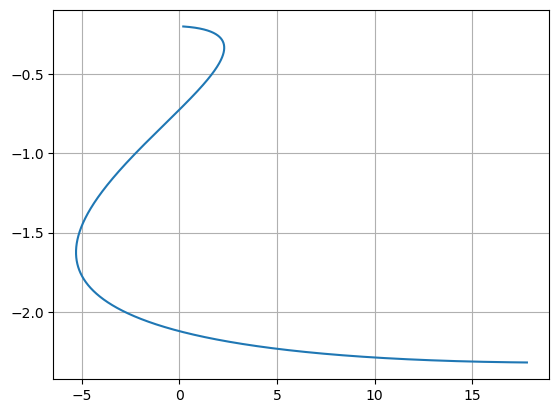

In [733]:
t_des = np.arange(0,40,1e-3)
x_des = +4e-5*t_des**4-7e-4*t_des**3-4e-2*t_des**2+6e-1*t_des+0.2
y_des = +1e-6*t_des**4-2e-5*t_des**3-2e-3*t_des**2-5e-3*t_des-0.2
plt.plot(x_des,y_des)
plt.grid(True)

In [734]:
lambda_1 = 200*sm.eye(3)
lambda_2 = 300*sm.eye(3)
display_expr(lambda_1)
display_expr(lambda_2)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [735]:
dotz1_1 = sm.diff(z1,z.T)
dotz1_1 = dotz1_1[0]
dotz1 = sm.Matrix([])
for i in range(sm.shape(dotz1_1)[0]):
    dotz1 = sm.Matrix.hstack(dotz1,sm.Matrix(dotz1_1[i]))
del dotz1_1
dotz1 = dotz1*B*u
display_expr(dotz1)

<IPython.core.display.Math object>

In [736]:
w = ddot_z1d - (lambda_1+lambda_2)*(dotz1-dot_z1d)-lambda_1*lambda_2*(z1-z1d)
display_expr(w)

<IPython.core.display.Math object>

In [737]:
# new state vector
s = sm.Matrix([z,u])
display_expr(s)

<IPython.core.display.Math object>

In [738]:
params = tuple(K_map.free_symbols)
print(params)
fun_K_map = sm.lambdify(params, K_map, modules='numpy')

params = tuple(g_map.free_symbols)
print(params)
fun_g_map = sm.lambdify(params, g_map, modules='numpy')

params = tuple(w.free_symbols)
print(params)
fun_w = sm.lambdify(params, w, modules='numpy')

Bu = B*u
params = tuple(Bu.free_symbols)
print(params)
fun_Bu = sm.lambdify(params, Bu, modules='numpy')
# params = tuple(Bu_map.free_symbols)
# print(params)
# fun_Bu_map = sm.lambdify(params, Bu_map, modules='numpy')

(beta_s2, theta, beta_s1)
(beta_s2, zeta_2, zeta_1, eta, theta, beta_s1)
(beta_s2, y, t, zeta_2, x, zeta_1, eta, theta, beta_s1)
(beta_s2, zeta_2, zeta_1, eta, theta, beta_s1)


In [741]:
def fun_Kinv_map(beta_s2, theta, beta_s1):
    return np.linalg.pinv(fun_K_map(beta_s2, theta, beta_s1))

def v(t,x,y,theta,beta_s1,beta_s2,eta,zeta_1,zeta_2):
    return np.dot( fun_Kinv_map(beta_s2, theta, beta_s1), (fun_g_map(beta_s2, zeta_2, zeta_1, eta, theta, beta_s1)-\
                                                fun_w(beta_s2, y, t, zeta_2, x, zeta_1, eta, theta, beta_s1)) )

def rhs(t, s):
    x,y,theta,beta_s1,beta_s2,eta,zeta_1,zeta_2 = s
    zero_tol = 1e-1
    if beta_s1 < zero_tol:
        beta_s1 = zero_tol
    elif beta_s1 > np.pi - zero_tol:
        beta_s1 = np.pi - zero_tol
    
    var_right_hand_side = np.vstack((fun_Bu(beta_s2, zeta_2, zeta_1, eta, theta, beta_s1),v(t,x,y,theta,beta_s1,beta_s2,eta,zeta_1,zeta_2)))

    return var_right_hand_side.reshape(1,8)[0]

In [742]:
T = 10  #0.5117 # simulation time
s0 = [0,0,-np.pi/2,0.1,0,0.1,0,0]
sol = sp.integrate.solve_ivp(rhs, [0, T], s0,method='RK23', dense_output=False,rtol=1e-3, atol=1e-5)

4.021894418108311
18.358095978915816
0.0
-1.444039626735286e+16
0.0
[-1.67849390e+14  1.38671777e+14  1.08861471e+15 -1.44403963e+16
  0.00000000e+00 -1.45101554e+32 -1.96482516e+32  0.00000000e+00]


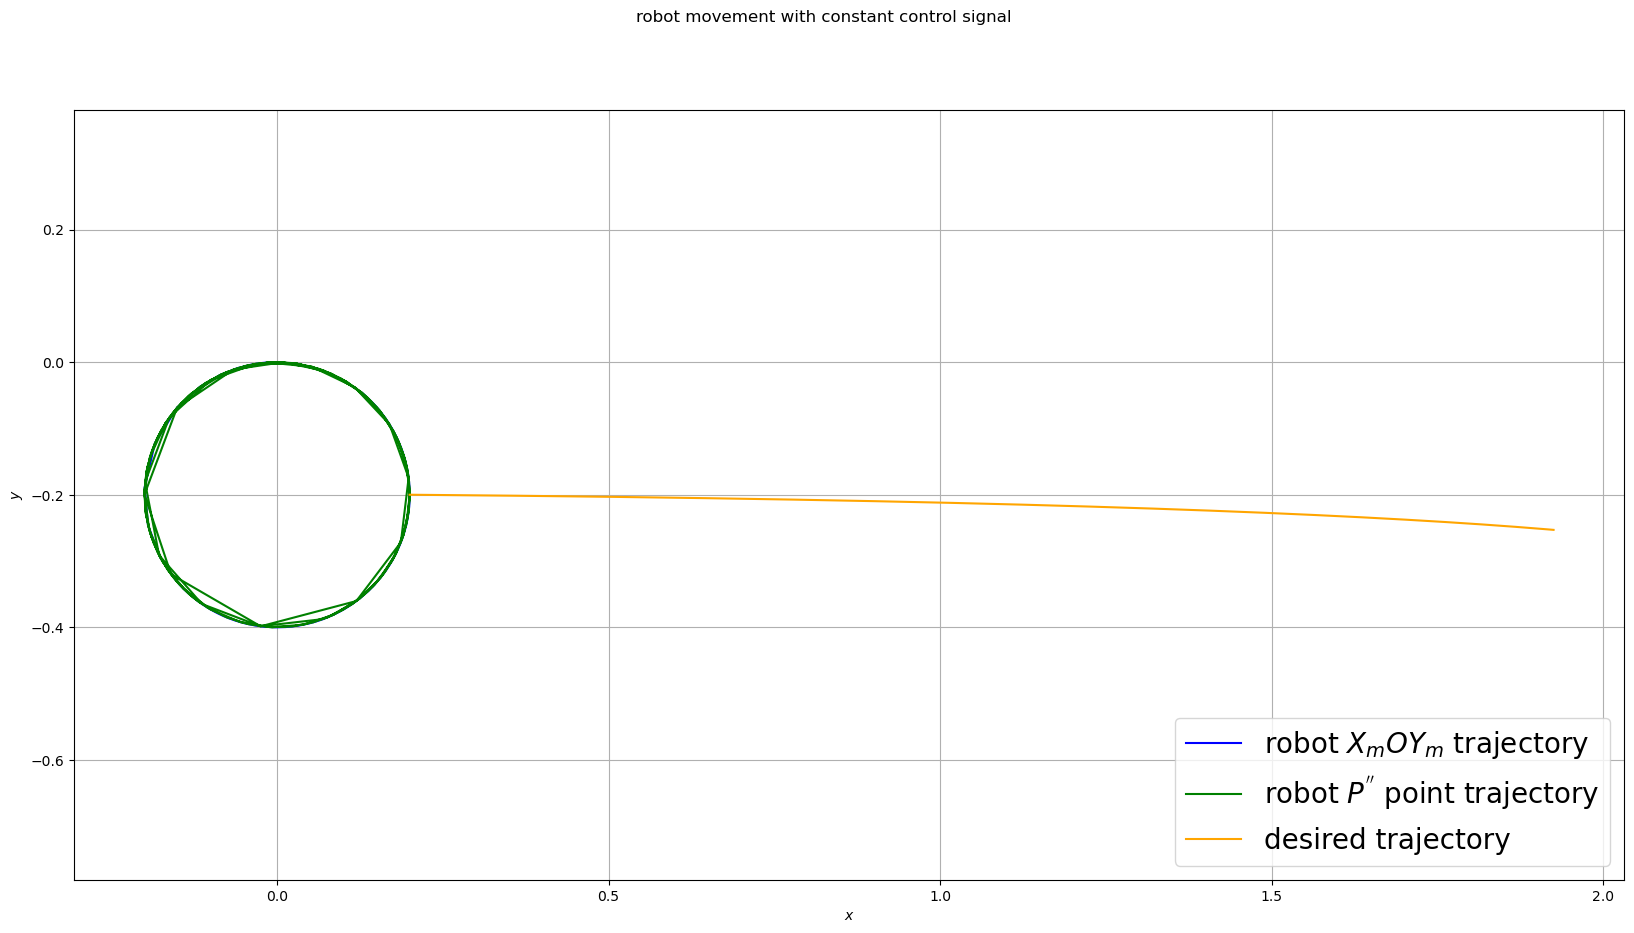

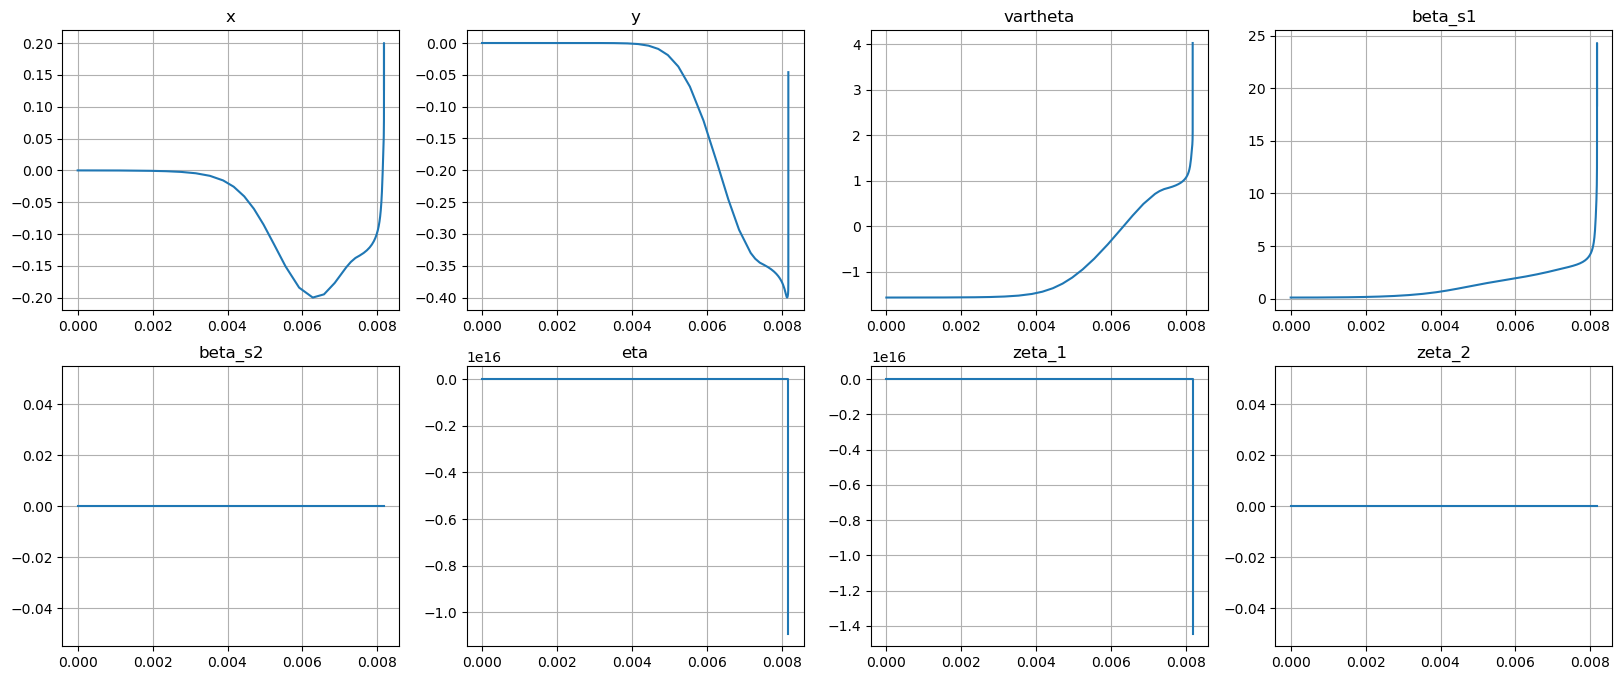

In [743]:
# dt = 0.1
# t = np.linspace(0, T, round(T/dt))
# z_traj = sol.sol(t)
t = sol.t
z_traj = sol.y

print(z_traj[2][-1])
print(z_traj[3][-1])
print(z_traj[4][-1])
print(z_traj[6][-1])
print(z_traj[7][-1])
print(rhs(t[-1],[z_traj[0][-1],z_traj[1][-1],z_traj[2][-1],z_traj[3][-1],z_traj[4][-1],z_traj[5][-1],z_traj[6][-1],z_traj[7][-1]]))

# computing z1
z1_traj = np.array([]).reshape(3,0)
for i in range(len(t)):
    z1_traj = np.hstack((z1_traj,fun_z1(z_traj[0][i],z_traj[1][i],z_traj[2][i],z_traj[3][i],z_traj[4][i])))

fig, ax = plt.subplots(1,1,figsize = (20,10))
labels = ['robot $X_mOY_m$ trajectory','robot $P^{\'\'}$ point trajectory','desired trajectory']
colours = ['b','g','orange']
ax.plot(z_traj[0],z_traj[1],label=labels[0],color=colours[0])
ax.plot(z1_traj[0],z1_traj[1],label=labels[1],color=colours[1])
mult = 0.1
ax.plot(x_des[:round((len(t_des)*mult))],y_des[:round((len(t_des)*mult))],label=labels[2],color=colours[2])

fig.suptitle("robot movement with constant control signal")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.grid(True)
ax.legend(fontsize="20",loc='lower right')
ax.axis('equal')
plt.show()

fig, ax = plt.subplots(2,4,figsize = (20,8))
for i in range(2):
    for j in range(4):
        ax[i][j].grid(True)
plt.subplot(241)
plt.plot(t,z_traj[0])
plt.title("x")
plt.subplot(242)
plt.plot(t,z_traj[1])
plt.title("y")
plt.subplot(243)
plt.plot(t,z_traj[2])
plt.title("vartheta")
plt.subplot(244)
plt.plot(t,z_traj[3])
plt.title("beta_s1")
plt.subplot(245)
plt.plot(t,z_traj[4])
plt.title("beta_s2")
plt.subplot(246)
plt.plot(t,z_traj[5])
plt.title("eta")
plt.subplot(247)
plt.plot(t,z_traj[6])
plt.title("zeta_1")
plt.subplot(248)
plt.plot(t,z_traj[7])
plt.title("zeta_2")
plt.show()

### State feedback, but with new dynamic system

In [744]:
z2 = K*u
Q_1 = sm.diff(z3,z.T)
Q_1 = Q_1[0]
Q = sm.Matrix([])
for i in range(sm.shape(Q_1)[0]):
    Q = sm.Matrix.hstack(Q,sm.Matrix(Q_1[i]))
del Q_1
Qp = Q*B
del Q

display_expr(z1)
display_expr(z2)
display_expr(z3)
Qp_map = Qp.subs(replacements,simultaneous=True)
display_expr(Qp_map)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [745]:
z1_1, z1_2 = sm.symbols("z1_1 z1_2")
calc_x = sm.solve(z1[0]-z1_1, x)[0] 
calc_y = sm.solve(z1[1]-z1_2, y)[0] 
display_expr(calc_x)
display_expr(calc_y)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [746]:
params = tuple(calc_x.free_symbols)
print(params)
fun_calc_x = sm.lambdify(params, calc_x, modules='numpy')

params = tuple(calc_y.free_symbols)
print(params)
fun_calc_y = sm.lambdify(params, calc_y, modules='numpy')

(z1_1, theta, beta_s1)
(z1_2, theta, beta_s1)


In [747]:
params = tuple(Qp_map.free_symbols)
print(params)
fun_Qp_map = sm.lambdify(params, Qp_map, modules='numpy')

params = tuple(z2.free_symbols)
print(params)
fun_z2 = sm.lambdify(params, z2, modules='numpy')

params = tuple(K.free_symbols)
print(params)
fun_K = sm.lambdify(params, K, modules='numpy')

(theta, beta_s1)
(beta_s2, zeta_2, zeta_1, eta, theta, beta_s1)
(beta_s2, theta, beta_s1)


In [753]:
def v(t,x,y,theta,beta_s1,beta_s2,eta,zeta_1,zeta_2):
    return np.dot( fun_Kinv_map(beta_s2, theta, beta_s1), (fun_g_map(beta_s2, zeta_2, zeta_1, eta, theta, beta_s1)-\
                                                fun_w(beta_s2, y, t, zeta_2, x, zeta_1, eta, theta, beta_s1)) )

def fun_Q_map(t,x,y,theta,beta_s1,beta_s2,eta,zeta_1,zeta_2):
    return np.dot( fun_Qp_map(theta, beta_s1), fun_Kinv_map(beta_s2, theta, beta_s1) )

def fun_Kinv(beta_s2, theta, beta_s1):
    return np.linalg.pinv(fun_K(beta_s2, theta, beta_s1))

def rhs(t, s):
    z1_1,z1_2,beta_s2,z2_1,z2_2,z2_3,theta,beta_s1 = s
    # zero_tol = 1e-1
    # if beta_s1 < zero_tol:
    #     beta_s1 = zero_tol
    # elif beta_s1 > np.pi - zero_tol:
    #     beta_s1 = np.pi - zero_tol
    
    x = fun_calc_x(z1_1, theta, beta_s1)
    y = fun_calc_y(z1_2, theta, beta_s1)

    u = np.dot( fun_Kinv(beta_s2, theta, beta_s1), np.array([z2_1,z2_2,z2_3]).reshape(3,1) )
    eta,zeta_1,zeta_2 = u[0][0],u[1][0],u[2][0]

    var_rhs = np.vstack(( fun_z2(beta_s2, zeta_2, zeta_1, eta, theta, beta_s1),
                            fun_g_map(beta_s2, zeta_2, zeta_1, eta, theta, beta_s1) - \
                                np.dot( fun_K_map(beta_s2, theta, beta_s1), v(t,x,y,theta,beta_s1,beta_s2,eta,zeta_1,zeta_2) ),
                            np.dot( fun_Q_map(t,x,y,theta,beta_s1,beta_s2,eta,zeta_1,zeta_2), fun_z2(beta_s2, zeta_2, zeta_1, eta, theta, beta_s1) ) ))

    return var_rhs.reshape(1,8)[0]

In [749]:
# np.dot( fun_Kinv(0, -np.pi/2, 0.1), np.array([0,0,0]).reshape(3,1) )

In [762]:
T = 5  #0.5117 # simulation time
s0 = [0.2,-0.2,0,0,0,0,-np.pi/2,2] # z1_1,z1_2,beta_s2,z2_1,z2_2,z2_3,theta,beta_s1
sol = sp.integrate.solve_ivp(rhs, [0, T], s0,method='RK23', dense_output=False,rtol=1e-2, atol=1e-4)

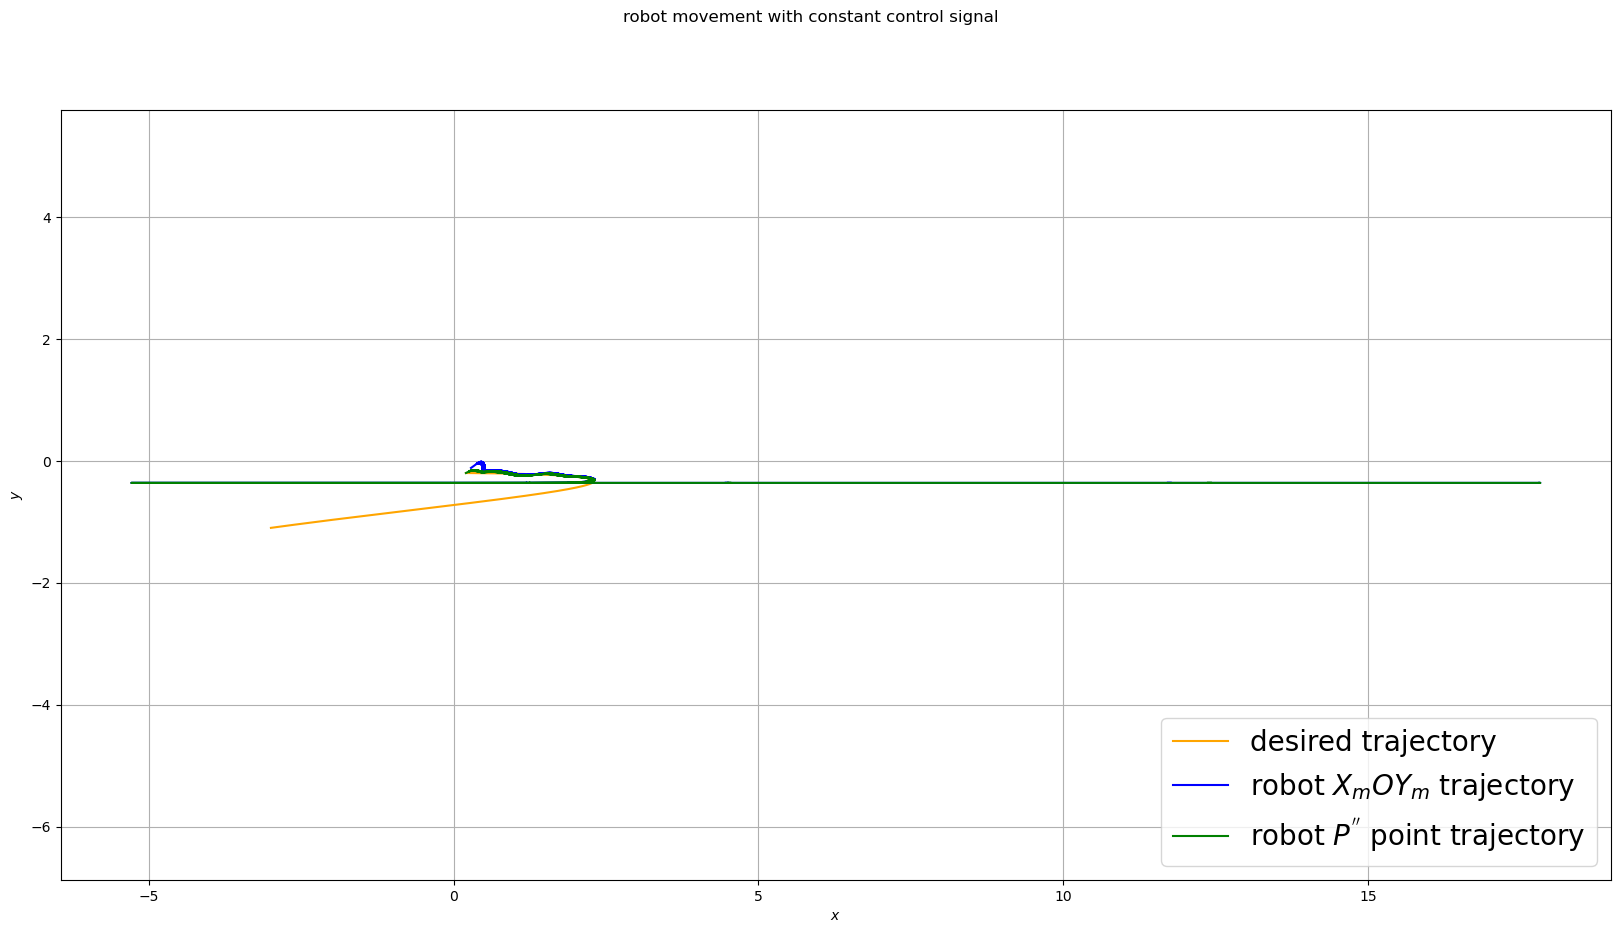

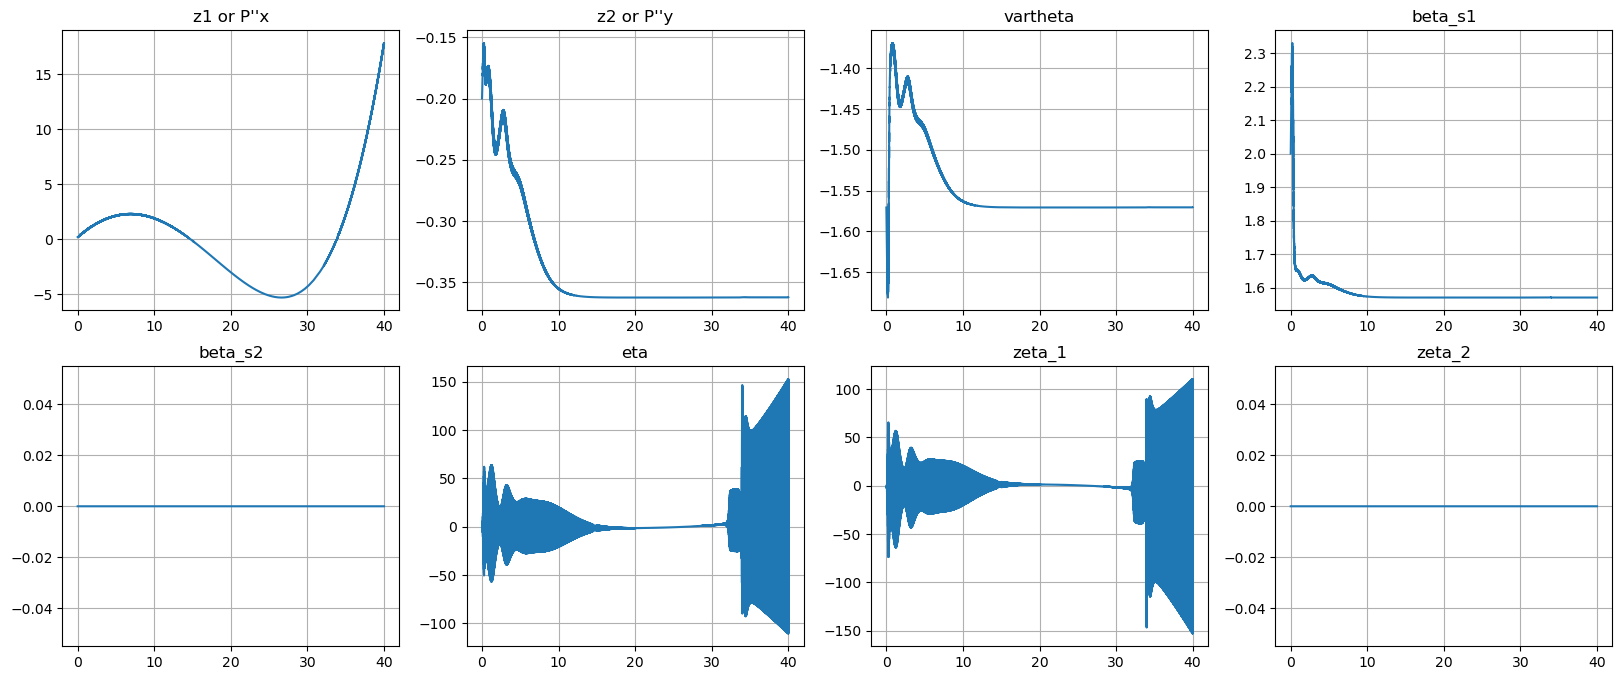

In [763]:
# dt = 0.1
# t = np.linspace(0, T, round(T/dt))
# z_traj = sol.sol(t)
t = sol.t
z1_traj = sol.y

# print(z_traj[2][-1])
# print(z_traj[3][-1])
# print(z_traj[4][-1])
# print(z_traj[6][-1])
# print(z_traj[7][-1])
# print(rhs(t[-1],[z_traj[0][-1],z_traj[1][-1],z_traj[2][-1],z_traj[3][-1],z_traj[4][-1],z_traj[5][-1],z_traj[6][-1],z_traj[7][-1]]))

fig, ax = plt.subplots(1,1,figsize = (20,10))
labels = ['robot $X_mOY_m$ trajectory','robot $P^{\'\'}$ point trajectory','desired trajectory']
colours = ['b','g','orange']
mult = 0.5
ax.plot(x_des[:round((len(t_des)*mult))],y_des[:round((len(t_des)*mult))],label=labels[2],color=colours[2])
ax.plot(fun_calc_x(z1_traj[0],z1_traj[6],z1_traj[7]), fun_calc_x(z1_traj[1],z1_traj[6],z1_traj[7]),label=labels[0],color=colours[0])
ax.plot(z1_traj[0],z1_traj[1],label=labels[1],color=colours[1])

fig.suptitle("robot movement with constant control signal")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.grid(True)
ax.legend(fontsize="20",loc='lower right')
ax.axis('equal')
plt.show()

fig, ax = plt.subplots(2,4,figsize = (20,8))
for i in range(2):
    for j in range(4):
        ax[i][j].grid(True)
plt.subplot(241)
plt.plot(t,z1_traj[0])
plt.title("z1 or P''x")
plt.subplot(242)
plt.plot(t,z1_traj[1])
plt.title("z2 or P''y")
plt.subplot(243)
plt.plot(t,z1_traj[6] )
plt.title("vartheta")
plt.subplot(244)
plt.plot(t,z1_traj[7])
plt.title("beta_s1")
plt.subplot(245)
plt.plot(t,z1_traj[2])
plt.title("beta_s2")

eta_v = np.array([])
zeta_1_v = np.array([])
zeta_2_v = np.array([])
for i in range(len(t)):
    u_v = np.dot( fun_Kinv(z1_traj[2][i], z1_traj[6][i], z1_traj[7][i]), np.array([z1_traj[3][i],z1_traj[4][i],z1_traj[5][i]]).reshape(3,1) )
    eta_v = np.append(eta_v,u_v[0][0])
    zeta_1_v = np.append(zeta_1_v,u_v[1][0])
    zeta_2_v = np.append(zeta_2_v,u_v[2][0])

plt.subplot(246)
plt.plot(t,eta_v)
plt.title("eta")
plt.subplot(247)
plt.plot(t,zeta_1_v)
plt.title("zeta_1")
plt.subplot(248)
plt.plot(t,zeta_2_v)
plt.title("zeta_2")
plt.show()

### Dynamic state feedback